In [37]:
# Train embedding models (word2vec)
from pre_process import PreProcessor
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os, tqdm

In [8]:
topics = ['Trai_dat', 'Hoa_hoc', 'Dong_vat', 'Khoa_hoc_moi_truong']
data_dir = './data'

def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

pre_processor = PreProcessor(stopword = None, tokenizer = 'vncorenlp')
    
data_mapper = dict()
for topic in topics:
    files = [os.path.join(data_dir, topic, f) for f in os.listdir(os.path.join(data_dir, topic)) if 'Q' in f]
    questions = [read_file(f) for f in files]
    data_mapper[topic] = [s.lower() for q in questions for s in pre_processor.pre_process(q)]

In [9]:
data_mapper

{'Trai_dat': ['hồng triều là thế_nào',
  'vì sao trong động đá_vôi nhũ_đá thì chảy xuống dưới còn măng_đá lại mọc hướng lên trên',
  'vì sao lại có hồ nước_ngọt hồ nước_mặn',
  'vì sao có_thể lợi_dụng thuỷ_triều để phát_điện',
  'có những phương_pháp nào để ngọt hoá nước_biển',
  'mùa hè vì sao thường có mưa giông',
  'vì sao xuất_hiện cầu_vồng trên bầu_trời',
  'khí_tượng thời_tiết và khí_hậu có gì khác nhau',
  'vì sao trước khi mưa giông trời rất oi_bức',
  'làm thế_nào để rút các khoáng_chất trong nước_biển ra',
  'vì sao nói nước_biển cũng là một nguồn năng_lượng',
  'vì sao trên cao_nguyên và núi cao cũng có ao_hồ',
  'hang_động được hình_thành như_thế_nào',
  'thế_nào là phao báo biển',
  'vùng đầm lầy được hình_thành như_thế_nào',
  'vì sao_băng tuyết trên đỉnh núi quanh_năm không tan',
  'khi gặp nạn trên biển tự cứu như_thế_nào',
  'vì sao biển được gọi là kho báu tài_nguyên hoá_học',
  'bốn mùa xuân hạ thu đông được phân_chia như_thế_nào',
  'trong một ngày không_khí lúc_nào

In [11]:
from collections import Counter
token_counter = Counter(list([token for sentences in data_mapper.values()
                                    for sentence in sentences
                                    for token in sentence.split()]))

In [15]:
token_counter.most_common(10)

[('vì', 494),
 ('sao', 492),
 ('có', 223),
 ('lại', 165),
 ('tại_sao', 149),
 ('không', 144),
 ('là', 126),
 ('có_thể', 109),
 ('được', 109),
 ('phải', 101)]

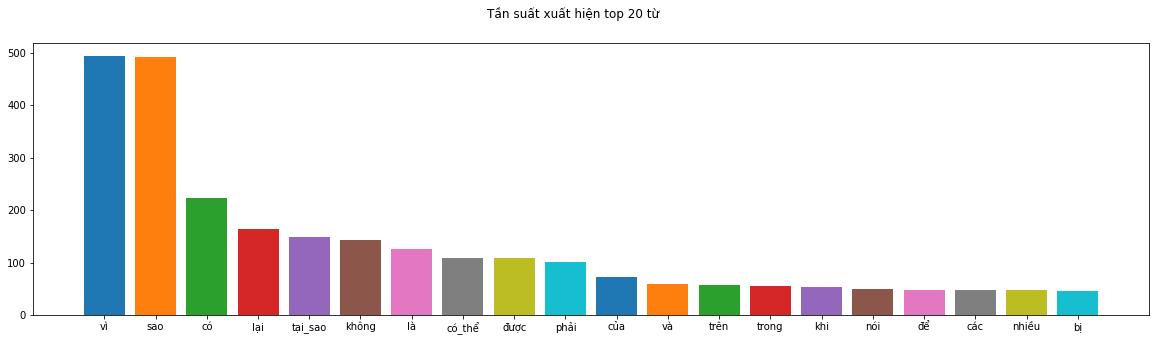

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 5))
for pair in token_counter.most_common(20):
    plt.bar(pair[0], pair[1])
plt.suptitle('Tần suất xuất hiện top 20 từ')
plt.show()

In [26]:
class SkipGramModel(nn.Module):
    """
    Skip-Gram model
    """
    def __init__(self, vocab_size: int, emb_dimension: int=200):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.init_emb()

    def init_emb(self):
        """
        init the weight as original word2vec do.
        :return: None
        """
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(0, 0)

    def forward(self, pos_u, pos_v, neg_v):
        """
        forward process.
        the pos_u and pos_v shall be the same size.
        the neg_v shall be {negative_sampling_count} * size_of_pos_u
        eg:
        5 sample per batch with 200d word embedding and 6 times neg sampling.
        pos_u 5 * 200
        pos_v 5 * 200
        neg_v 5 * 6 * 200
        :param pos_u:  positive pairs u, list
        :param pos_v:  positive pairs v, list
        :param neg_v:  negative pairs v, list
        :return:
        """
        emb_u = self.u_embeddings(pos_u)  # batch_size * emb_size
        emb_v = self.v_embeddings(pos_v)  # batch_size * emb_size
        emb_neg = self.v_embeddings(neg_v)  # batch_size * neg sample size * emb_size

        pos_score = torch.mul(emb_u, emb_v).squeeze()
        pos_score = torch.sum(pos_score, dim=1)
        pos_score = F.logsigmoid(pos_score)

        neg_score = torch.bmm(emb_neg, emb_u.unsqueeze(2)).squeeze()
        neg_score = F.logsigmoid(-neg_score)

        return -1 * (torch.sum(pos_score) + torch.sum(neg_score))

    def save_embedding(self, id2word: dict, file_name: str='word_vectors.txt', use_cuda: bool=False):
        """
        Save all embeddings to file.
        As this class only record word id, so the map from id to word has to be transfered from outside.
        :param id2word: map from word id to word.
        :param file_name: file name.
        :param use_cuda:
        :return:
        """
        if use_cuda:
            embedding = self.u_embeddings.weight.cpu().data.numpy()
        else:
            embedding = self.u_embeddings.weight.data.numpy()
        fout = open(file_name, 'w', encoding='utf-8')
        fout.write('%d %d\n' % (len(id2word), self.emb_dimension))
        for wid, w in id2word.items():
            e = embedding[wid]
            e = ' '.join(map(lambda x: str(x), e))
            fout.write('%s %s\n' % (w, e))

In [30]:
import numpy as np
from collections import defaultdict
from collections import deque


np.random.seed(1)


class DataHanlder:
    """
    input date handler
    for storing/sampling data, etc.
    """
    def __init__(self, log_filename: str,
                 min_count: int=5,
                 sub_sampling_t: float=1e-5,
                 neg_sampling_t: float=0.75,
                 batch_size: int=64,
                 neg_sample_count: int=5,
                 half_window_size: int=2,
                 read_data_method='memory'):
        """
        init function.
        :param log_filename: word2vec format -> item1 item2 ... itemk\n, each line a user log
        :param min_count: the same min_count as in word2vec
        :param sub_sampling_t: sub sampling rate, higher than that would be sub sampled using
                                the word2vec paper using:    p(w_i) = 1 - sqrt(sub_sampling / freq)
                                the word2vec code using:     p(w_i) = 1 - (sqrt(sub_sampling / freq) + sub_sampling / freq)
                                we use word2vec code subsampling method here.
        :param neg_sampling_t: the negative sampling t as in the word2vec. seems not shown in the paper, but implemented in
                                the code:
                                    p(w_i) = f(w_i) ** neg_sampling / sum(f(w_i) ** neg_sampling for w_i in vocab)
        :param read_data_method: method to read data:
                                    'memory': load all the sentence to memory, fast but cost memory.
                                    'file': load data from file, slower but save memory
        """
        assert read_data_method in ('memory', 'file')
        self.log_filename = log_filename
        self.min_count = min_count
        self.sub_sampling_t = sub_sampling_t
        self.neg_sampling_t = neg_sampling_t
        self.sentences = deque()
        self.read_data_method = read_data_method
        print('read dataset...')
        self.vocab, self.word2id, self.id2word, self.total_word_count, self.sentence_len = self.gen_vocab()
        print(f'got vocab {len(self.vocab)}, total_word_count {self.total_word_count}')
        print('gen negative sample table...')
        self.neg_sample_table = self.gen_negative_sample_table()
        print('done.\ngen sub sampling table...')
        self.sub_sampling_table = self.gen_subsample_table()
        print('done.')
        self.batch_size = batch_size
        self.sentence_cursor = 0  # sentence cursor for generating batch
        self.neg_sample_count = neg_sample_count
        self.half_window_size = half_window_size

    def gen_vocab(self):
        """
        from log file generate vocabulary
        :return: {item_id: freq}
        """
        assert self.log_filename != ''
        vocab_freq_dict = defaultdict(int)
        total_word_count = 0
        total_sent_count = 0
        with open(self.log_filename, encoding='utf-8') as f:
            for line in f:
                total_sent_count += 1
                item_ids = line.strip().split()
                if self.read_data_method == 'memory':
                    self.sentences.append(item_ids)
                for item_id in item_ids:
                    vocab_freq_dict[item_id] += 1
                    total_word_count += 1
        vocab, word2id, id2word = {}, {}, {}
        index = 0
        for item_id, freq in vocab_freq_dict.items():
            if freq < self.min_count:
                continue
            vocab[item_id] = freq
            word2id[item_id] = index
            id2word[index] = item_id
            index += 1
        return vocab, word2id, id2word, total_word_count, total_sent_count

    def gen_subsample_table(self):
        """
        sub sampling rate, higher than that would be sub sampled using
            the word2vec paper using:    p(w_i) = 1 - sqrt(sub_sampling / freq)
            the word2vec code using:     p(w_i) = 1 - (sqrt(sub_sampling / freq) + sub_sampling / freq)
        we use word2vec code sub sampling method here.
        :return: {word_id: sample_score}
        """
        def sub_sampling(_freq):
            return (self.sub_sampling_t / 1.0 / _freq) ** 0.5 + self.sub_sampling_t / 1.0 / _freq
        # word freq count to word freq ratio
        sub_sample_tbl = {item: freq / 1.0 / self.total_word_count
                          for item, freq in self.vocab.items()
                          if freq / 1.0 / self.total_word_count > self.sub_sampling_t}
        # freq to score
        sub_sample_tbl = {item: sub_sampling(_freq) for item, _freq in sub_sample_tbl.items()}
        # word to id
        sub_sample_tbl = {self.word2id[i]: j for i, j in sub_sample_tbl.items() if j < 1}
        return sub_sample_tbl

    def gen_negative_sample_table(self):
        """
        implemented same as word2vec c code.
        The way this selection is implemented in the C code is interesting. They have a large array with 100M elements
        (which they refer to as the unigram table). They fill this table with the index of each word in the vocabulary
        multiple times, and the number of times a word’s index appears in the table is given by P(wi) * table_size.
            p(w_i) = f(w_i) ** neg_sampling / sum(f(w_i) ** neg_sampling for w_i in vocab)
        :return:
        """
        sample_tbl_size = 1e8
        sample_tbl = []
        pow_freq = np.array(list(self.vocab.values())) ** self.neg_sampling_t
        pow_total_freq = sum(pow_freq)
        r = pow_freq / pow_total_freq
        count = np.round(r * sample_tbl_size)
        for item_id, _count in enumerate(count):
            sample_tbl += [item_id] * int(_count)
        sample_tbl = np.array(sample_tbl)
        return sample_tbl

    def gen_batch(self):
        """
        yield batch
        :return: pos_pairs -> [(w1, w2) * batch_size ], neg samples -> [self.neg_sample_count * batch_size]
        """
        f = open(self.log_filename)
        pos_pairs = []
        pos_1, pos_2, neg_samples = [], [], []
        while True:
            while len(pos_pairs) < self.batch_size:
                # pos
                sentence = []
                if self.read_data_method == 'memory':
                    sentence = self.sentences.popleft()
                elif self.read_data_method == 'file':
                    sentence = f.readline()
                    if not sentence:
                        f = open(self.log_filename)
                        sentence = f.readline()
                    sentence = sentence.strip().split()
                self.sentence_cursor += 1
                # to word id
                word_ids = [self.word2id[item_id] for item_id in sentence if item_id in self.word2id]
                for i, word_id in enumerate(word_ids):
                    pos_pairs += [(word_id, word_ids[j])
                                  for j in range(max(0, i - self.half_window_size),
                                                 min(i + self.half_window_size + 1, len(word_ids) - 1))
                                  if j != i]
                if self.read_data_method == 'memory':
                    self.sentences.append(sentence)
            # neg
            for pos1, pos2 in pos_pairs[len(neg_samples):]:
                pos_1.append(pos1)
                pos_2.append(pos2)
                neg_samples.append(self.negative_sampling(pos1, pos2))
            yield (pos_1[:self.batch_size], pos_2[:self.batch_size], neg_samples[:self.batch_size])
            pos_pairs = pos_pairs[self.batch_size:]
            pos_1 = pos_1[self.batch_size:]
            pos_2 = pos_2[self.batch_size:]
            neg_samples = neg_samples[self.batch_size:]

    def negative_sampling(self, pos1, pos2):
        """
        negative sample, shall not equal to pos1 and pos2
        :param pos1:
        :param pos2:
        :return:
        """
        negs = []
        while len(negs) < self.neg_sample_count:
            _negs = np.random.choice(self.neg_sample_table, size=self.neg_sample_count - len(negs))
            negs += [i for i in _negs if i != pos1 and i != pos2]

        return negs[:self.neg_sample_count]

    def thread_read_data_(self):
        """
        useless since GIL exists.
        though it is a pure IO thread, it still does not accelerate.
        :return:
        """
        f = open(self.log_filename)
        while True:
            if len(self.sentences) < 1000:
                sentence = f.readline()
                if not sentence:
                    f = open(self.log_filename)
                    sentence = f.readline()
                item_ids = sentence.strip().split(' ')
                self.sentences.append(item_ids)

In [31]:
class Word2Vec:
    def __init__(self, log_filename: str,
                 output_filename: str,
                 embedding_dimension: int=100,
                 batch_size: int=128,
                 iteration: int=1,
                 initial_lr: float=0.025,
                 min_count: int=5,
                 sub_sampling_t: float = 1e-5,
                 neg_sampling_t: float = 0.75,
                 neg_sample_count: int = 5,
                 half_window_size: int = 2,
                 read_data_method: str='memory'):
        """
        init func
        """
        self.data = DataHanlder(log_filename=log_filename,
                                batch_size=batch_size,
                                min_count=min_count,
                                sub_sampling_t=sub_sampling_t,
                                neg_sampling_t=neg_sampling_t,
                                neg_sample_count=neg_sample_count,
                                half_window_size=half_window_size,
                                read_data_method=read_data_method)
        self.output_filename = output_filename
        self.embedding_dimension = embedding_dimension
        self.batch_size = batch_size
        self.half_window_size = half_window_size
        self.iter = iteration
        self.initial_lr = initial_lr
        self.sg_model = SkipGramModel(len(self.data.vocab), self.embedding_dimension)
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.sg_model.cuda()
        self.optimizer = optim.SGD(self.sg_model.parameters(), lr=self.initial_lr)

    def train(self):
        i = 0
        # total 2 * self.half_window_size * self.data.total_word_count,
        # for each sent, (1 + 2 + .. + half_window_size) * 2 more pairs has been calculated, over all * sent_len
        # CAUTION: IT IS NOT AN ACCURATE NUMBER, JUST APPROXIMATELY COUNT.
        approx_pair = 2 * self.half_window_size * self.data.total_word_count - \
                      (1 + self.half_window_size) * self.half_window_size * self.data.sentence_len
        batch_count = self.iter * approx_pair / self.batch_size
        for pos_u, pos_v, neg_samples in self.data.gen_batch():
            i += 1
            if self.data.sentence_cursor > self.data.sentence_len * self.iter:
                # reach max iter
                break
            # train iter
            pos_u = Variable(torch.LongTensor(pos_u))
            pos_v = Variable(torch.LongTensor(pos_v))
            neg_v = Variable(torch.LongTensor(neg_samples))
            if self.use_cuda:
                pos_u, pos_v, neg_v = [i.cuda() for i in (pos_u, pos_v, neg_v)]

            # print(len(pos_u), len(pos_v), len(neg_v))
            self.optimizer.zero_grad()
            loss = self.sg_model.forward(pos_u, pos_v, neg_v)
            loss.backward()
            self.optimizer.step()

            if i % 100 == 0:
                # print(loss)
                print("step: %d, Loss: %0.8f, lr: %0.6f" % (i, loss.item(), self.optimizer.param_groups[0]['lr']))
            if i % (100000 // self.batch_size) == 0:
                lr = self.initial_lr * (1.0 - 1.0 * i / batch_count)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = lr

        self.sg_model.save_embedding(self.data.id2word, self.output_filename, self.use_cuda)

In [33]:
with open('tokenized_questions.txt', 'w') as f:
    for sentences in data_mapper.values():
        for sentence in sentences:
            f.write(sentence + '\n')

In [38]:
w2v = Word2Vec('./tokenized_questions.txt', 'model_test.txt', iteration=100)
w2v.train()

read dataset...
got vocab 282, total_word_count 7899
gen negative sample table...
done.
gen sub sampling table...
done.
step: 100, Loss: 457.71014404, lr: 0.025000
step: 200, Loss: 336.34771729, lr: 0.025000
step: 300, Loss: 328.65966797, lr: 0.025000
step: 400, Loss: 337.86785889, lr: 0.025000
step: 500, Loss: 326.38244629, lr: 0.025000
step: 600, Loss: 335.32452393, lr: 0.025000
step: 700, Loss: 311.73663330, lr: 0.025000
step: 800, Loss: 285.56924438, lr: 0.024045
step: 900, Loss: 346.42999268, lr: 0.024045
step: 1000, Loss: 299.90341187, lr: 0.024045
step: 1100, Loss: 301.75573730, lr: 0.024045
step: 1200, Loss: 294.83029175, lr: 0.024045
step: 1300, Loss: 279.43304443, lr: 0.024045
step: 1400, Loss: 270.68057251, lr: 0.024045
step: 1500, Loss: 298.03738403, lr: 0.024045
step: 1600, Loss: 274.30270386, lr: 0.023090
step: 1700, Loss: 289.79135132, lr: 0.023090
step: 1800, Loss: 258.99932861, lr: 0.023090
step: 1900, Loss: 284.14810181, lr: 0.023090
step: 2000, Loss: 300.73681641, lr

In [39]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import datapath
from pathlib import Path

model = KeyedVectors.load_word2vec_format(Path.cwd() / 'tokenized_questions.txt', binary=False)

print(model.most_similar(positive='bảo_vệ'))

ValueError: invalid literal for int() with base 10: 'hồng'